In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import re

The European Cup 2020 is planned to start on the 11th June 2021. The team selection of the managers will be announced close to this date. Therefore, we need to find secondary sources that predict the players that will be selected to play for their country. We scrape the players for every participating nation and link those to the Fifa ratings. The dataset for the Fifa ratings comes from [Kaggle](https://www.kaggle.com/batuhandemirci/fifa-2021-team-and-player-dataset) and has been scraped from the website [Sofifa](https://sofifa.com/).

## 1. Scrape the expected selection of players of the participating nations

In [9]:
base_url = 'https://www.fussball-wm.pro/em-2021/gruppen/'
groups_request = requests.get(base_url)
soup = BeautifulSoup(groups_request.text, 'html.parser')

In [10]:
team_urls = {}
for table in soup.findAll("table"):
    for team in table.findAll('a'):
        team_urls[team.text] = team.get('href')

In [179]:
stop_words = ['tor', 
              'verteidigung', 
              'verteidiger', 
              'sechser',
              'interessant',
              'rechts',
              'links',
              'dreierkette',
              'stürmer',
              '0er-position',
              'außen',
              'hinten',
              'angriff',
              'nummer eins',
              'abwehrseite',
              'sturmzentrum',
              'dreierreihe',
              'außenbahnen',
              'sturm',
              'mittelfeld',
              'zentrum',
              'nationalmannschaft',
              'nummer',
              'einser'
             ]

In [12]:
def parse_team(team_url):
    def check_name(name):
        for word in stop_words:
            if word.lower() in name.lower():
                return False
        return True
    
    team_request = requests.get(team_url)
    soup = BeautifulSoup(team_request.text, 'html.parser')
    players_soup = soup.findAll('strong')
    players = []
    for player in players_soup:
        player_name = player.text
        if check_name(player_name):
            players.append(player_name)
    return players
teams = {}
for team, team_url in team_urls.items():
    teams[team] = parse_team(team_url)

In [113]:
df_teams = pd.DataFrame(pd.DataFrame.from_dict(teams, orient='index').stack(), columns=['Name'])

In [114]:
translation_dict = {'Türkei':'Turkey',
                    'Dänemark':'Denmark',
                    'Niederlande':'Netherlands',
                    'Italien':'Italy',
                    'Finnland':'Finland',
                    'Wales':'Wales',
                    'England':'England',
                    'Portugal':'Portugal',
                    'Schweden':'Schweden',
                    'Belgien':'Belgium',
                    'Österreich':'Austria',
                    'Schweiz': 'Switzerland', 
                    'Russland':'Russia',
                    'Nordmazedonien':'North Macedonia', 
                    'Spanien':'Spain',
                    'Ungarn':'Hungary',
                    'Kroatien':'Croatia',
                    'Schweden':'Sweden',
                    'Schottland':'Scotland',
                    'Polen':'Poland',
                    'Frankreich':'France',
                    'Tschechien':'Czech Republic',
                    'Slowakei':'Slovakia',
                    'Deutschland':'Germany',
                    'Ukraine':'Ukraine' }

In [115]:
df_teams = df_teams.reset_index().drop(columns='level_1').rename(columns={'level_0':'Nationality'})
df_teams['Nationality'] = df_teams['Nationality'].map(translation_dict)
df_teams['Name'] = df_teams['Name'].str.lstrip(' ')

In [116]:
df_teams['Name'] = df_teams['Name'].str.lstrip(' ')

## Link the Fifa dataset to the participating teams

In [119]:
fifa_players = pd.read_csv('data/fifa_dataset/players.csv')
fifa_players

,int_player_id,str_player_name,str_positions,dt_date_of_birth,int_height,int_weight,int_overall_rating,int_potential_rating,str_best_position,int_best_overall_rating,...,int_international_reputations,str_work_rate,str_body_type,int_dribbling,int_curve,int_fk_accuracy,int_long_passing,int_ball_control,str_player_speciality,str_trait
0,1,Lionel Andrés Messi Cuccittini,"RW, ST, CF",1987-06-24,170,72,93,93,RW,93,...,5,Medium/ Low,Unique,96,93,94,91,96,"['Dribbler', 'Distance Shooter', 'FK Specialis...","['Finesse Shot', 'Long Shot Taker (AI)', 'Spee..."
1,2,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",1985-02-05,187,83,92,92,ST,92,...,5,High/ Low,Unique,88,81,76,77,92,"['Aerial Threat', 'Dribbler', 'Distance Shoote...","['Power Free-Kick', 'Flair', 'Long Shot Taker ..."
2,3,Jan Oblak,GK,1993-01-07,188,87,91,93,GK,91,...,3,Medium/ Medium,Unique,12,13,14,40,30,NaN,"['GK Long Throw', 'Comes For Crosses']"
3,4,Kevin De Bruyne,"CAM, CM",1991-06-28,181,70,91,91,CAM,91,...,4,High/ High,Unique,88,85,83,93,92,"['Dribbler', 'Playmaker\xa0', 'Engine', 'Dista...","['Injury Prone', 'Leadership', 'Early Crosser'..."
4,5,Neymar da Silva Santos Júnior,"LW, CAM",1992-02-05,175,68,91,91,LW,91,...,5,High/ Medium,Unique,95,88,89,81,95,"['Speedster', 'Dribbler', 'Playmaker\xa0', 'FK...","['Injury Prone', 'Flair', 'Speed Dribbler (AI)..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18997,18998,张梦炫,CB,1999-04-26,177,70,47,52,CB,49,...,1,Low/ Low,Normal (170-185),19,21,22,25,24,NaN,NaN
18998,18999,Vani Da Silva,ST,2003-03-30,171,58,47,67,CAM,51,...,1,Medium/ Medium,Lean (170-185),53,43,31,37,44,NaN,NaN
18999,19000,夏奥,CB,1999-02-11,178,66,47,55,CB,49,...,1,Medium/ Medium,Lean (170-185),27,23,21,29,42,NaN,NaN
19000,19001,Ben Hough,CM,2003-06-22,175,65,47,67,CAM,51,...,1,Medium/ Medium,Lean (170-185),46,40,35,50,48,NaN,NaN


The following cell will scrape a football website where the authors speak about the most probable team for the European Championship.

In [154]:
from fuzzywuzzy import fuzz
def find_fuzzy_reference(possible_players, name):
    """
    The function recovers the names of the players where the names diverge
    in the two different datasets. As the names might be spelled differently
    (accents etc.) we need to use a library that is able to recover the most
    similar player. The fuzzywuzzy library is based on the Levenshtein distance.
    """
    max_fuzz = 0
    max_player = None
    
    for index, player in possible_players.iterrows():
        fuzz_ = fuzz.ratio(name, player['str_player_name'])
        if fuzz_ > max_fuzz:
            max_fuzz = fuzz_
            max_player = player
            
    if type(max_player) == pd.Series:
        return max_player['int_player_id']
    else:
        return None

merge_list = []
for index, row in df_teams.iterrows():
    name = row['Name']
    nationality = row['Nationality']
    player = fifa_players[fifa_players['str_player_name'] == name]
    
    if len(player.index) == 1:
        merge_list.append(player['int_player_id'].values[0])
    elif len(player.index) > 1:
        
        if (fifa_players.loc[player.index[0]]['dt_date_of_birth'] == fifa_players.loc[player.index[1]]['dt_date_of_birth']):
            merge_list.append(player['int_player_id'].iloc[0])
        else:
            same_nation_player = player[player['str_nationality'] == nationality]
            
            if len(same_nation_player) == 1:
                merge_list.append(same_nation_player['int_player_id'].iloc[0])
                
            else:
                merge_list.append(None)
                
    else:
        fifa_players_nation = fifa_players[fifa_players['str_nationality']==nationality]
        player_index = find_fuzzy_reference(fifa_players_nation, name)
        merge_list.append(player_index)

In [157]:
df_teams['merge_list'] = merge_list

In [210]:
EC_teams = df_teams.merge(fifa_players, how='left', left_on='merge_list', right_on='int_player_id')
EC_teams = EC_teams.drop_duplicates()
EC_teams = EC_teams.infer_objects()

## Explore the teams

### Strongest players in the tournament

In [211]:
print('The ten strongest players in the competition by the FIFA overall rating are:')
for index, player in EC_teams.sort_values('int_overall_rating', ascending=False).head(10).iterrows():
        print(f"{player['str_player_name']} with an overall rating of {player['int_overall_rating']} playing for {player['str_nationality']}.")

The ten strongest players in the competition by the FIFA overall rating are:
Cristiano Ronaldo dos Santos Aveiro with an overall rating of 92.0 playing for Portugal.
Robert Lewandowski with an overall rating of 91.0 playing for Poland.
Kevin De Bruyne with an overall rating of 91.0 playing for Belgium.
Marc-André ter Stegen with an overall rating of 90.0 playing for Germany.
Kylian Mbappé Lottin with an overall rating of 90.0 playing for France.
Virgil van Dijk with an overall rating of 90.0 playing for Netherlands.
Sergio Ramos García with an overall rating of 89.0 playing for Spain.
Thibaut Courtois with an overall rating of 89.0 playing for Belgium.
Manuel Neuer with an overall rating of 89.0 playing for Germany.
N'Golo Kanté with an overall rating of 88.0 playing for France.


### Number of players in every team
We want to remark that in the final team selection, there will be a fixed number of 23 players. Here we consider the players that are, according to experts, the most probable to participate in the tournament. If the final selections are available, we can easily update the teams.

<AxesSubplot:xlabel='Nationality'>

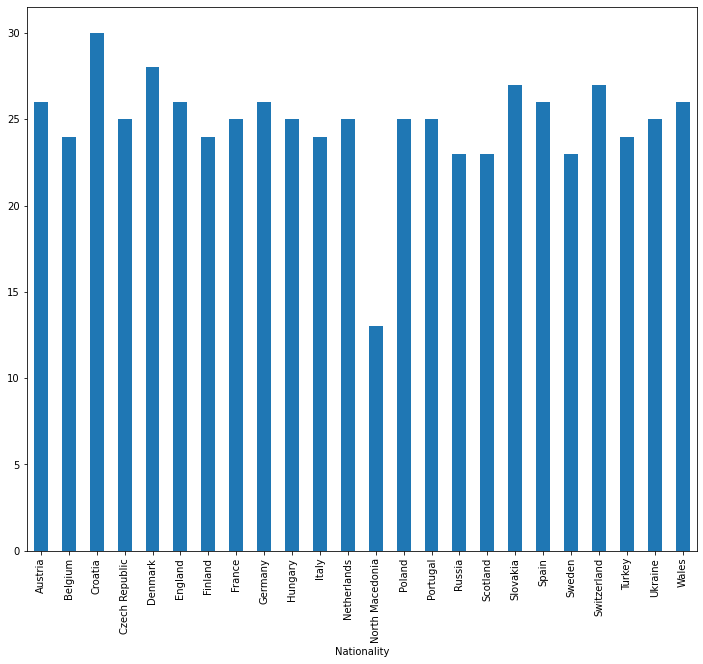

In [231]:
fig, ax = plt.subplots(figsize=(12,10))
EC_teams.groupby('Nationality').size().plot(kind='bar')

We can see that most of the teams have around 25 players. We notice that we have scraped much less player names of North Macedonia. It might be necessary to manually complete these information.

### Comparison of the average overall team ratings

<AxesSubplot:xlabel='Nationality'>

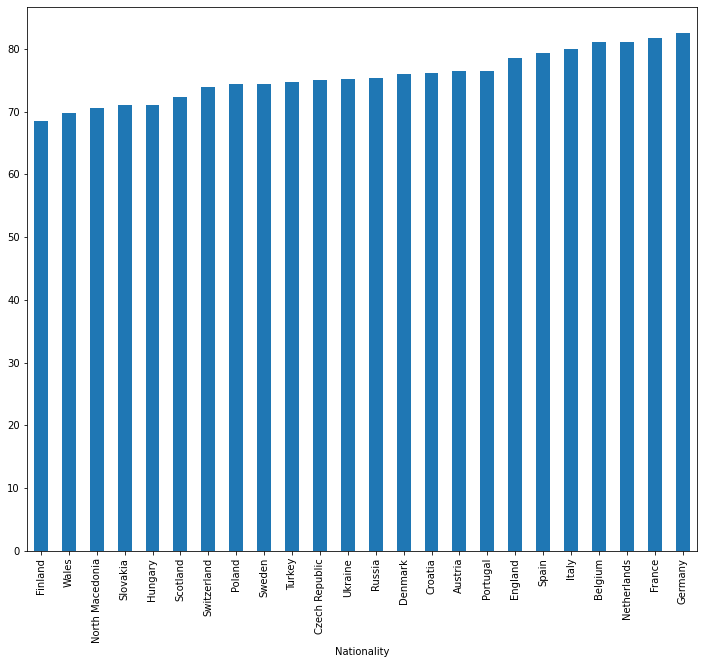

In [230]:
fig, ax = plt.subplots(figsize=(12,10))
EC_teams.groupby('Nationality')['int_overall_rating'].mean().sort_values().plot(kind='bar')

Just looking at the overall_ratings of the players, Germany France and the Netherlands are the strongest competitors in the tournament.

### Average age per team

In [213]:
from datetime import datetime
EC_teams['dt_date_of_birth'] = pd.to_datetime(EC_teams['dt_date_of_birth'])
EC_teams['age'] = (datetime.now() - EC_teams['dt_date_of_birth']).astype('<m8[Y]')
EC_teams.groupby('Nationality')['age'].mean().sort_values(ascending=False)

Nationality
Sweden             29.260870
Russia             29.173913
Belgium            28.625000
Croatia            28.333333
Finland            28.083333
France             28.040000
Netherlands        28.000000
Czech Republic     27.920000
Spain              27.760000
Ukraine            27.720000
Scotland           27.695652
Austria            27.692308
Poland             27.680000
Denmark            27.642857
Hungary            27.160000
Germany            26.884615
Turkey             26.666667
Slovakia           26.666667
Switzerland        26.629630
Italy              26.500000
North Macedonia    26.384615
Wales              25.769231
England            25.423077
Portugal           25.400000
Name: age, dtype: float64

Here we can see the sorted list of the average age of the team. Sweden has the oldest team and Portugal has the youngest one. 

### Heading abilities of the players
In order to keep the graphs more comprehensible, we are only going to show the data of two teams in this graph.

<AxesSubplot:xlabel='int_height', ylabel='int_heading_accuracy'>

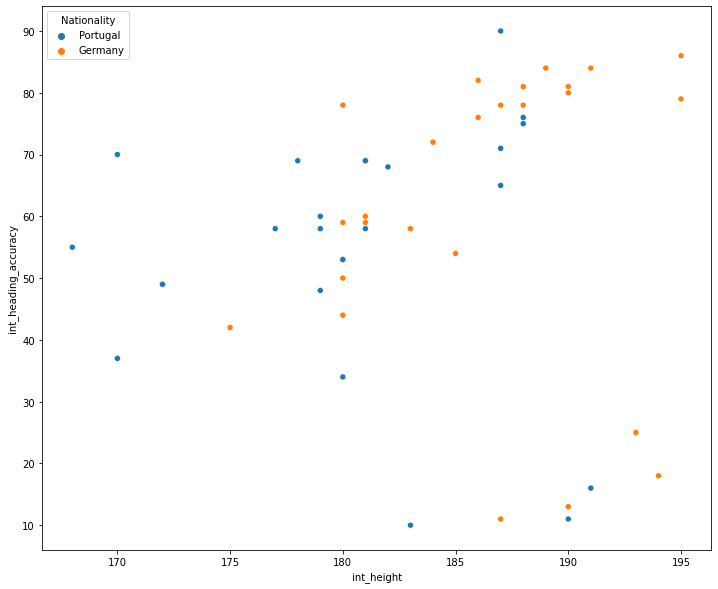

In [225]:
teams_subset = ['Portugal', 'Germany']
fig, ax = plt.subplots(figsize=(12,10))
sns.scatterplot(data=EC_teams[EC_teams['Nationality'].isin(teams_subset)], x='int_height', y='int_heading_accuracy', hue='Nationality')

We can see that the Germans are taller than that a lot of them have a high heading accuracy. We could identify with such an analysis a weakness of the portugese team. Nevertheless, the graph is still quite noisy and it would be good to identify the defenders and attacking players in order to compare who plays against who. This would refine our analysis. Moreover it would be nice to see what player we are talking about when hovering over it. This is a feature that we should implement in our graphs. 

We can build many more of these graphs were we compare the abilities of different players. In our project, we will need to find ways to compare all these different abilities of adversary plays in a meaningful way.